# Imports and GPU detection

In [1]:
# PyTorch
import torch
from torch import nn

# NumPy
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Math
import math

# Time
import time

# Checks to see if gpu is available. If it is, use it else use cpu
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Using {device}: {torch.cuda.get_device_name()}')
else:
    device = torch.device('cpu')
    print('No GPU found, using cpu')

Using cuda: Tesla T4


In [2]:
!mkdir -p nn-based-multistate-solver-for-se

In [3]:
path = "nn-based-multistate-solver-for-se"

In [4]:
!ls nn-based-multistate-solver-for-se

# Function for initialization NN-based solver hyperparameters

In [5]:
# Initializes NN-based solver hyperparameters
def initParams(activ_func: str, D: int, M: int, H: list, L: float, 
               B: int, lr: float, weight_decay: int, I: int,
               wrmax: float, wamax: float, wbmax: float, sigma: float):
    params = dict()
    # Direct solver hyperparameters
    params['activ_func'] = activ_func # Activation function
    params['D'] = D # Dimension of the coordinate space
    params['M'] = M # Dimension of the final space (number 
      # of bottom states we want to find)
    params['H'] = H # Sizes of NN hidden layers
    params['L'] = L # Box size
    # Indirect solver hyperparameters
    params['B'] = B # Batch size
    params['lr'] = lr # Learning rate
    params['weight_decay'] = weight_decay # Weight decay 
      # (Adam optimizer parameter)
    params['I'] = I # Amount of training iterations
    # Loss function weights limitations
    params['wrmax'] = wrmax 
    params['wamax'] = wamax
    params['wbmax'] = wbmax
    params['sigma'] = sigma
    # Path to save and load model
    stringH = ""
    for i in range(len(H)):
        stringH += f"{H[i]},"
    params['nnbmssPath'] = path+f"/D{D}_M{M}_H{stringH}_L{L}.pt"
    # Path to save figures
    params['nnbmssPathFigure'] = f"_{activ_func}_D{D}_M{M}_H{stringH}_L{L}_WRMAX{params['wrmax']}_WAMAX{params['wamax']}_WBMAX{params['wbmax']}.pdf"
    # Path to save loss function weights
    params['wPath'] = path+f"/D{D}_M{M}_H{stringH}_L{L}.txt"
    return params

# Solver class

In [6]:
f0 = lambda x: torch.sin(x)
f1 = lambda x: torch.cos(x)
f2 = lambda x: -torch.sin(x)

# f0 = lambda x: torch.tanh(x)
# f1 = lambda x: 1/torch.cosh(x)**2
# f2 = lambda x: -2*torch.sinh(x)/torch.cosh(x)**3

class Perceptron(nn.Module):
  def __init__(self, params):
    assert len(params['H']) > 0, "List of hidden layers' widths is empty"
    super(Perceptron, self).__init__()
    self.D = params['D'] # Dimension of the initial space
    self.M = params['M'] # Dimension of the final space
    self.N = len(params['H']) # Number of the hidden layers
    self.L = params['L'] # Box size
    self.stack = nn.Sequential() # Structure of the perceptron
    for n in range(self.N + 1):
      if (n == 0):
        self.stack.append(nn.Linear(self.D, params['H'][0]))
      elif (n == self.N):
        self.stack.append(nn.Linear(params['H'][-1], self.M))
      else:
        self.stack.append(nn.Linear(params['H'][n-1], params['H'][n]))
      self.stack.append(nn.Tanh())
    self.stack.to(device)
  
  # Normal distribution
  def weight(self, x: torch.Tensor, mean: float, std: float):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    return 1 / (std * math.sqrt(2 * math.pi))**self.D \
      * torch.exp(-0.5 * torch.sum((x - mean)**2, axis=1) / std**2)
  
  def stack_gradient(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    result = torch.zeros((x.shape[0], self.D, self.M)).to(device)
    # Computation of the y
    y = [None] * (self.N + 1)
    y[0] = x
    for i in range(self.N):
      # y(i+1)
      y[i+1] = self.stack[i*2+1](self.stack[i*2](y[i]))
    # Computation of the result
    for d in range(self.D):
      # dy(1)dx
      dydx = f1(self.stack[0](y[0])) * self.stack[0].weight[:,d]
      for i in range(1, self.N + 1):
        # dy(i)dx
        dydx =  f1(self.stack[i*2](y[i])) \
          * torch.matmul(dydx, self.stack[i*2].weight.t())
      # keeping result
      result[:,d,:] = dydx
    return result
  
  def stack_laplacian(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    preresult = torch.zeros((x.shape[0], self.D, self.M)).to(device)
    # Computation of the y
    y = [None] * (self.N + 1)
    y[0] = x
    for i in range(self.N):
      # y(i+1)
      y[i+1] = self.stack[i*2+1](self.stack[i*2](y[i]))
    # Computation of the result
    for d in range(self.D):
      # dy(1)dx
      dydx = f1(self.stack[0](y[0])) * self.stack[0].weight[:,d]
      # d2y(2)dx2
      d2ydx2 = f2(self.stack[0](y[0])) * self.stack[0].weight[:,d]**2
      for i in range(1, self.N + 1):
        # d2y(i)dx2
        d2ydx2 = f2(self.stack[i*2](y[i])) \
          * torch.matmul(dydx, self.stack[i*2].weight.t())**2 \
          + f1(self.stack[i*2](y[i])) \
          * torch.matmul(d2ydx2, self.stack[i*2].weight.t())
        # dy(i)dx
        dydx =  f1(self.stack[i*2](y[i])) \
          * torch.matmul(dydx, self.stack[i*2].weight.t())
      # keeping preresult
      preresult[:,d,:] = d2ydx2
    return torch.sum(preresult, axis=1) 
  
  def amplitude(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    # mask = (torch.sum(abs(x)<=self.L, axis=1) == self.D).to(device)
    result = torch.ones((x.shape[0], self.M)).to(device)
    # result = torch.mul(result, 1 / torch.sum(self.stack(x)**2, axis=0))
    result = torch.mul(result.t(), 
                       torch.exp(- torch.sum(x**2, axis=1) / 2)).t()
    # result = torch.mul(result.t(),
    #                    (1 - torch.sum(x**2, axis=1) / self.L**2) * mask).t()
    assert result.shape[1] == self.M, "Wrong shape 1 of the result"
    assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
    return result
  
  def amplitude_gradient(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    # mask = (torch.sum(abs(x)<=self.L, axis=1) == self.D).to(device)
    result = torch.ones((x.shape[0], self.D, self.M)).to(device)
    # s = self.stack(x)
    # sg = self.stack_gradient(x)
    for d in range(self.D):
      # first term
      a = torch.ones((x.shape[0], self.M)).to(device)
      a = torch.mul(a.t(), 
                    torch.exp(- torch.sum(x**2, axis=1) / 2) \
                    * (- 2 * x[:,d] / 2)).t()
      # a = torch.mul(a.t(), -2 * x[:,d] / self.L**2 * mask).t()
      # keeping result
      result[:,d,:] = a #+ b
    return result

  def amplitude_laplacian(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    # mask = (torch.sum(abs(x)<=self.L, axis=1) == self.D).to(device)
    a = torch.ones((x.shape[0], self.M)).to(device)
    result = torch.mul(a.t(), 
                       torch.exp(- torch.sum(x**2, axis=1) / 2) \
                       * (torch.sum((-2*x/2)**2, axis=1) \
                          - 2 * torch.sum(torch.ones_like(x)/2, axis=1))).t()
    # result = torch.mul(a.t(), -2 * self.D / self.L**2 * mask).t()
    return result
    
  def forward(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    result = self.stack(x).to(device) * self.amplitude(x).to(device) # Multiply by amplitude
    assert result.shape[1] == self.M, "Wrong shape 1 of the result"
    assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
    return result
  
  def gradient(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    result = torch.zeros((x.shape[0], self.D, self.M)).to(device)
    a = self.amplitude(x)
    sg = self.stack_gradient(x)
    s = self.stack(x)
    ag = self.amplitude_gradient(x)
    for d in range(self.D):
      result[:,d,:] = sg[:,d,:] * a + s * ag[:,d,:]
    return result

  def laplacian(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    result = self.stack_laplacian(x) * self.amplitude(x) \
      + self.stack(x) * self.amplitude_laplacian(x) \
      + 2 * torch.sum(self.stack_gradient(x) * self.amplitude_gradient(x), 
                      axis=1)
    return result
  
  def wavefunction_norm2(self, x: torch.Tensor, mean: float, std: float):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    result = torch.zeros(self.M).to(device)
    f = self.forward(x)
    w = self.weight(x, mean, std)
    for m in range(self.M):
      result[m] = torch.mean(abs(f[:,m])**2 / w)
    return result
  
  def mean_hamiltonian(self, x: torch.Tensor, mean: float, std: float):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    result = torch.zeros(self.M).to(device)
    f = self.forward(x)
    l = self.laplacian(x)
    w = self.weight(x, mean, std)
    v = 0.5 * torch.sum(x**2, axis=1)
    for m in range(self.M):
      result[m] = torch.mean(f[:,m] * (-0.5 * l[:,m] + v * f[:,m]) / w)
    return result
  
  def energies(self, x: torch.Tensor, mean: float, std: float):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    return self.mean_hamiltonian(x, mean, std) \
      / self.wavefunction_norm2(x, mean, std)
  
  def load_model(self, params):
    self.load_state_dict(params['nnbmssPath'])
  
  def save_model(self, params):
    torch.save(self.state_dict(), params['nnbmssPath'])

  def train_step(self, optimizer, loss_function, B: int, mean: float,
                 std: float, loss_weights: dict, sigma: float):
    # Normal distributed x
    x = torch.normal(mean=mean, std=std, size=(B, self.D)).to(device)
    e = self.energies(x, mean, std)
    f = self.forward(x)
    w = self.weight(x, mean, std)
    # Residual
    residual = -0.5 * self.laplacian(x) \
      + 0.5 * torch.mul(f.t(), torch.sum(x**2, axis=1)).t() \
      - torch.mul(f, e)
    # Orthonormalization
    norm = torch.sqrt(self.wavefunction_norm2(x, mean, std))
    a = torch.sum((norm - torch.tensor(1).to(device))**2)
    b = torch.zeros(self.M, self.M).to(device)#.to(device)
    for m1 in range(1, self.M):
      for m2 in range(0, m1):
        b[m1,m2] = torch.mean(f[:,m1] * f[:,m2] / w)**2
    # Loss
    loss = loss_function(
        loss_weights['r'] * torch.mean(torch.mean((residual)**2, axis=0) / norm**2)
        + + loss_weights['e'] * torch.sum(e)
        + loss_weights['a'] * a 
        + loss_weights['b'] * torch.sum(b),
        torch.tensor(0.0).to(device))
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
    self.L = self.L * sigma
    return loss.item(), np.mean(residual.cpu().detach().numpy(), axis=0), \
      a.cpu().detach().numpy(), \
      torch.sum(b).cpu().detach().numpy(), e.cpu().detach().numpy()
  
  def train_loop(self, params):
    start_time = time.time()
    e_list = [None] * params['I']
    l_list = [None] * params['I']
    r_list = [None] * params['I']
    a_list = [None] * params['I']
    b_list = [None] * params['I']
    loss_weights = dict()
    loss_weights['r'] = 1
    loss_weights['a'] = 1
    loss_weights['b'] = 1
    # params['loss_weights'] = loss_weights
    x = torch.normal(mean=0, std=self.L/math.sqrt(2), size=(params['B'], self.D)).to(device)
    loss_weights['e'] = torch.sum(self.energies(x, mean=0., std=self.L/math.sqrt(2))).cpu().detach()
    optimizer = torch.optim.AdamW(params=list(self.parameters()), 
                                 lr=params['lr'], 
                                 weight_decay=params['weight_decay'])
    # Main loop
    print('i,\t Loss,\t Sorted energies,\t Time [s]')
    
    # File to write loss weights
    file = open(params['wPath'], 'w')
    file.write("WR,WE,WA,WB")
    
    for i in range(params['I']):
        l_list[i], r_list[i], a_list[i], b_list[i], e_list[i] = self.train_step(optimizer, 
                                                                              nn.MSELoss(),
                                                                              B=params['B'],
                                                                              mean=0.,
                                                                              std=self.L/math.sqrt(2),
                                                                              loss_weights=loss_weights,
                                                                              sigma=params['sigma'])
        if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
        if i % 500 == 0:
            print(f"{i:3d}\t {l_list[i]:.4E}\t {np.sort(e_list[i])}\t {time.time()-start_time}")
            # Empty cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # Save model parameters
            self.save_model(params)
        
        if i % 100 == 0:
            # if (loss_weights['r'] == 500) and (loss_weights['a'] == 10) and (loss_weights['b'] == 10):
            #     break
            
            x = torch.normal(mean=0, std=self.L/math.sqrt(2), size=(params['B'], self.D)).to(device)
            e = self.energies(x, mean=0, std=self.L/math.sqrt(2))
            f = self.forward(x)
            w = self.weight(x, mean=0, std=self.L/math.sqrt(2))
            # Residual
            residual = -0.5 * self.laplacian(x) \
              + 0.5 * torch.mul(f.t(), torch.sum(x**2, axis=1)).t() \
              - torch.mul(f, e)
            # Orthonormalization
            norm = torch.sqrt(self.wavefunction_norm2(x, mean=0, std=self.L/math.sqrt(2)))
            a = torch.sum((norm - torch.tensor(1).to(device))**2)
            b = torch.zeros(self.M, self.M).to(device)#.to(device)
            for m1 in range(1, self.M):
                for m2 in range(0, m1):
                    b[m1,m2] = torch.mean(f[:,m1] * f[:,m2] / w)**2
        
            loss_weights['r'] = min(1/ torch.mean(torch.mean((residual)**2, axis=0) / norm**2).cpu().detach(), params['wrmax'])
            loss_weights['e'] = 1/torch.sum(e).cpu().detach()
            loss_weights['a'] = min(1/a.cpu().detach(), params['wamax'])
            loss_weights['b'] = min(1/torch.sum(b).cpu().detach(), params['wbmax'])
            
            loss_weight_norm = 4
            
            loss_weights['r'] /= loss_weight_norm
            loss_weights['e'] /= loss_weight_norm
            loss_weights['a'] /= loss_weight_norm
            loss_weights['b'] /= loss_weight_norm
            
            print("loss_weights:")
            print(loss_weights)
            
            file.write(f"\n{loss_weights['r']},{loss_weights['e']},{loss_weights['a']},{loss_weights['b']}")

            # Empty cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
    # Empty cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()   
        
    file.close()
    return e_list, l_list, r_list, a_list, b_list, time.time()-start_time

# Initialize and train solver

In [7]:
torch.cuda.empty_cache()

In [8]:
params = initParams(activ_func='sin', D=3, M=10, H=[100,100,100], L=6, 
                    B=int(2**13), lr=1e-3, weight_decay=1e-3, I=30000,
                    wrmax=1e3, wamax=1e1, wbmax=1e2,
                    sigma=1.0)
perceptron = Perceptron(params).to(device)

In [9]:
e_list, l_list, r_list, a_list, b_list, t = perceptron.train_loop(params)

i,	 Loss,	 Sorted energies,	 Time [s]
  0	 1.9549E+05	 [1.526747  1.6619804 1.7404027 1.9350828 1.9685649 2.1343791 2.2094142
 2.4640498 2.6182518 2.6625617]	 2.4481277465820312
loss_weights:
{'r': 250.0, 'a': tensor(0.0429), 'b': tensor(2.0555), 'e': tensor(0.0142)}
loss_weights:
{'r': 250.0, 'a': tensor(0.0604), 'b': tensor(0.2821), 'e': tensor(0.0120)}
loss_weights:
{'r': 250.0, 'a': tensor(0.0598), 'b': tensor(0.2606), 'e': tensor(0.0119)}
loss_weights:
{'r': 250.0, 'a': tensor(0.0597), 'b': tensor(0.2631), 'e': tensor(0.0119)}
loss_weights:
{'r': 250.0, 'a': tensor(0.0574), 'b': tensor(0.3582), 'e': tensor(0.0119)}
500	 9.3473E-01	 [1.5321674 1.637591  1.899891  1.923162  1.9473466 2.091678  2.4067922
 2.570844  2.6058512 2.6731346]	 71.32089567184448
loss_weights:
{'r': 250.0, 'a': tensor(0.0586), 'b': tensor(0.3250), 'e': tensor(0.0118)}
loss_weights:
{'r': 250.0, 'a': tensor(0.0579), 'b': tensor(0.3095), 'e': tensor(0.0118)}
loss_weights:
{'r': 250.0, 'a': tensor(0.0561), 'b': 

In [10]:
perceptron.save_model(params)

## How many time it takes

In [11]:
ht = int(t//3600)
mt = int(t//60 - ht*60)
st = int(t - 3600*ht - 60*mt)
print(f"It takes {ht:}h {mt:}m {st}s")

It takes 0h 51m 25s


# Figures

## Terms of the loss function

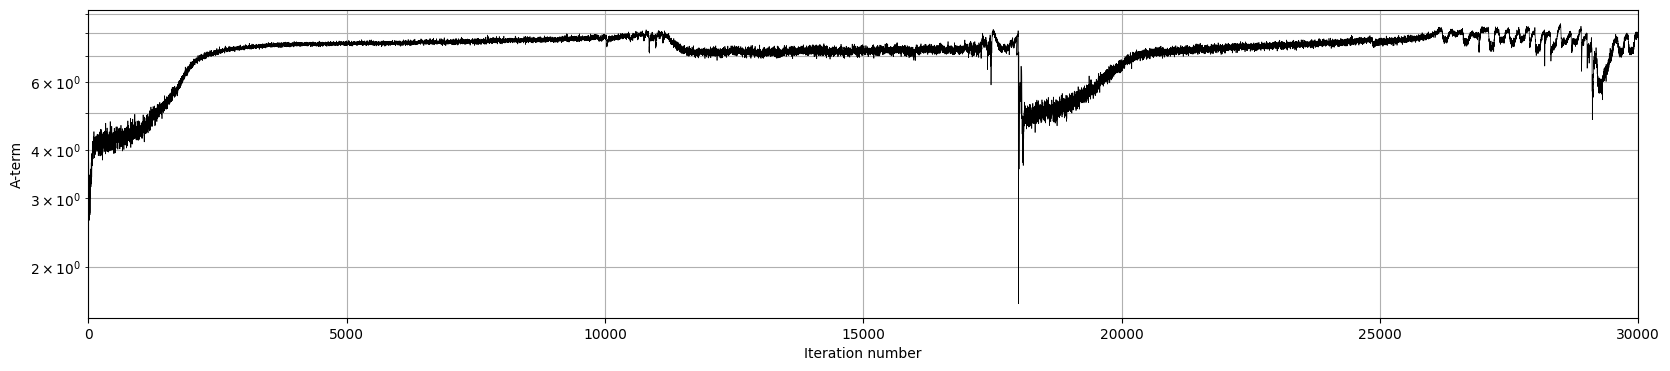

In [12]:
fig, ax = plt.subplots(1,1,figsize=(20,4))
ax.plot(a_list,color='black',linewidth=0.5)
ax.set_xlim(0,params['I'])
ax.set_yscale('log')
ax.set_ylabel('A-term')
ax.set_xlabel('Iteration number')
ax.grid(True, which="both")
plt.savefig(path+"/a"+params['nnbmssPathFigure'])

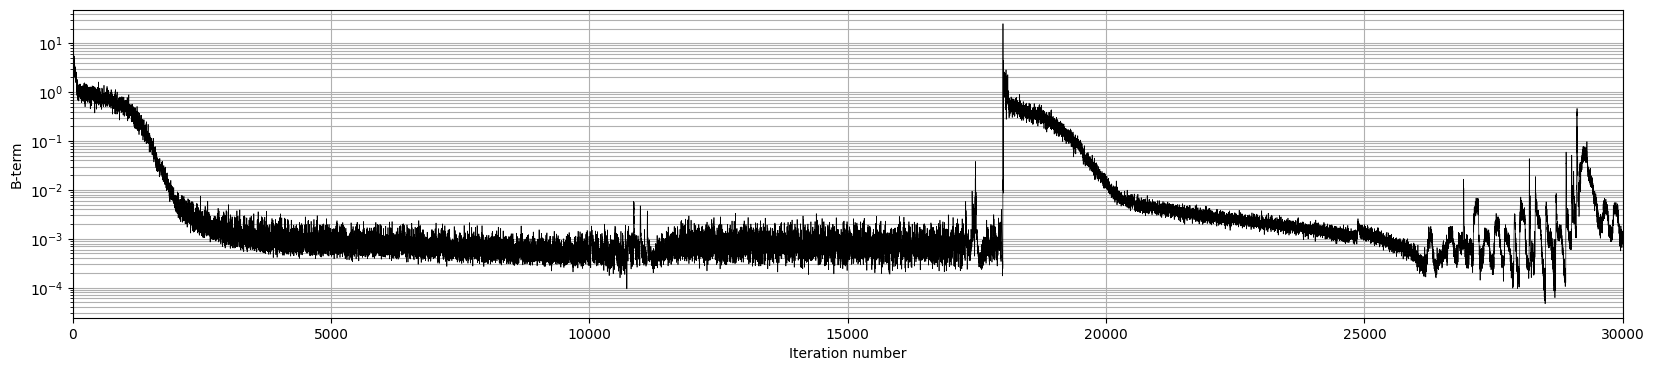

In [13]:
fig, ax = plt.subplots(1,1,figsize=(20,4))
ax.plot(b_list,color='black',linewidth=0.5)
ax.set_xlim(0,params['I'])
ax.set_yscale('log')
ax.grid(True, which="both")
ax.set_ylabel('B-term')
ax.set_xlabel('Iteration number')
plt.savefig(path+"/b"+params['nnbmssPathFigure'])

/tmp/ipykernel_24/3443978870.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0,1e2)


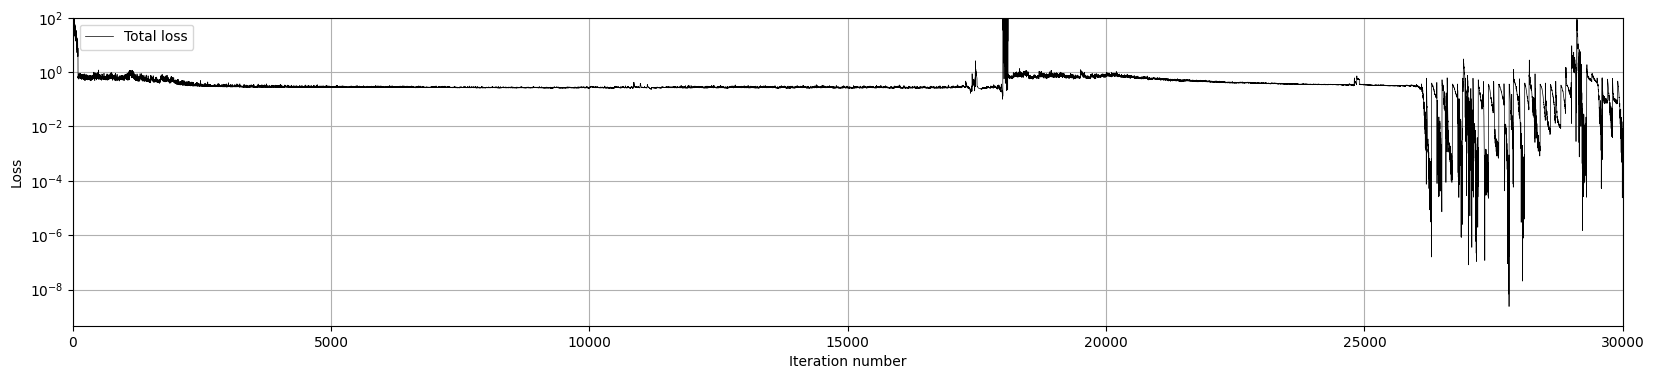

In [14]:
# loss
fig, ax = plt.subplots(1,1,figsize=(20,4))

ax.plot(l_list, linewidth=0.5, color='black', label='Total loss')
# ax.plot(np.array(l_list) - params['alpha']*np.array(a_list) - params['beta']*np.array(b_list), linewidth=0.5, color='green', label='1st term')
# ax.plot(a_list, linewidth=0.5, color='red', label='Normalisation')
# ax.plot(b_list, linewidth=0.5, color='blue', label='Orthogonalization')
# ax.axhline(y=10,linewidth=0.5, linestyle='--', color='grey')
# ax.plot(np.sum())
ax.legend()
ax.set_yscale('log')
ax.set_xlim(0,params['I'])
ax.set_ylabel('Loss')
ax.set_xlabel('Iteration number')
ax.set_ylim(0,1e2)
ax.grid(True, which="both")
plt.savefig(path+"/loss"+params['nnbmssPathFigure'])

## Loss weights

In [15]:
import pandas as pd

lw = pd.read_csv(params['wPath'])
lw

,WR,WE,WA,WB
0,250.000000,0.014225,0.042855,2.055499
1,250.000000,0.012029,0.060383,0.282089
2,250.000000,0.011865,0.059760,0.260559
3,250.000000,0.011862,0.059674,0.263086
4,250.000000,0.011885,0.057433,0.358230
...,...,...,...,...
295,250.000000,0.042191,0.035133,25.000000
296,129.122101,-0.013083,0.032464,25.000000
297,250.000000,0.030740,0.035279,25.000000
298,166.097687,-0.012647,0.031820,25.000000


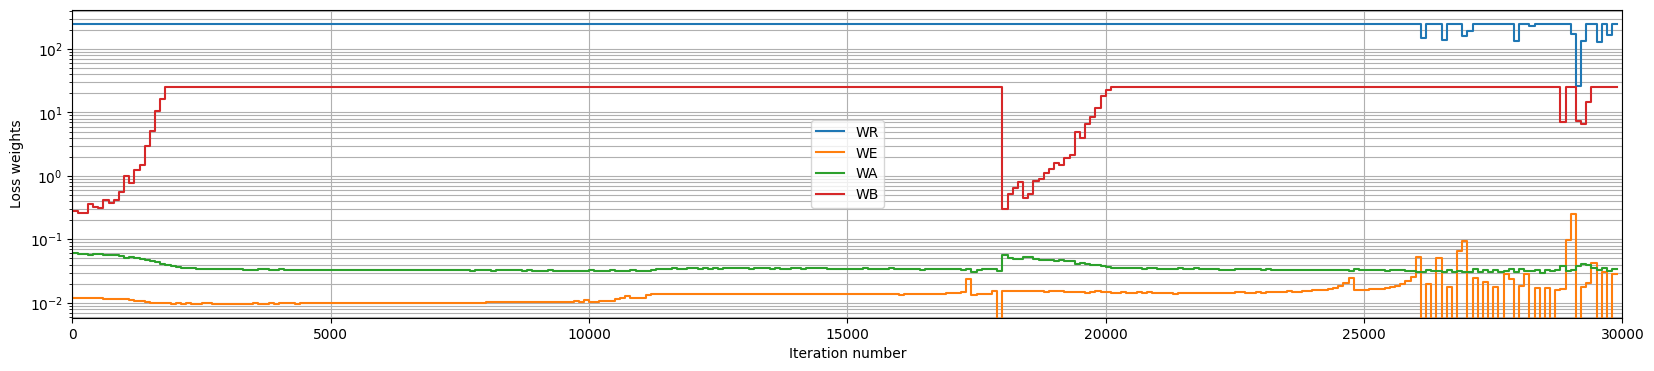

In [16]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

for k in lw.columns:
    ax.step(np.arange(params['I']//100)*100, lw[k].to_numpy(), label=k)
ax.set_xlim(0,params['I'])
ax.set_ylabel('Loss weights')
ax.set_xlabel('Iteration number')
ax.set_yscale('log')
ax.grid(True, which="both")
ax.legend()
plt.savefig(path+"/w"+params['nnbmssPathFigure'])

## General figure

/tmp/ipykernel_24/4168393953.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax[1,1].table(cellText = np.array([vars,vals]).transpose(),


[-7.493084   -7.109567   -6.428808   -3.3888795  -1.4520386  -0.67287683
  1.192539    1.3083893   1.4648478   2.6050649 ]


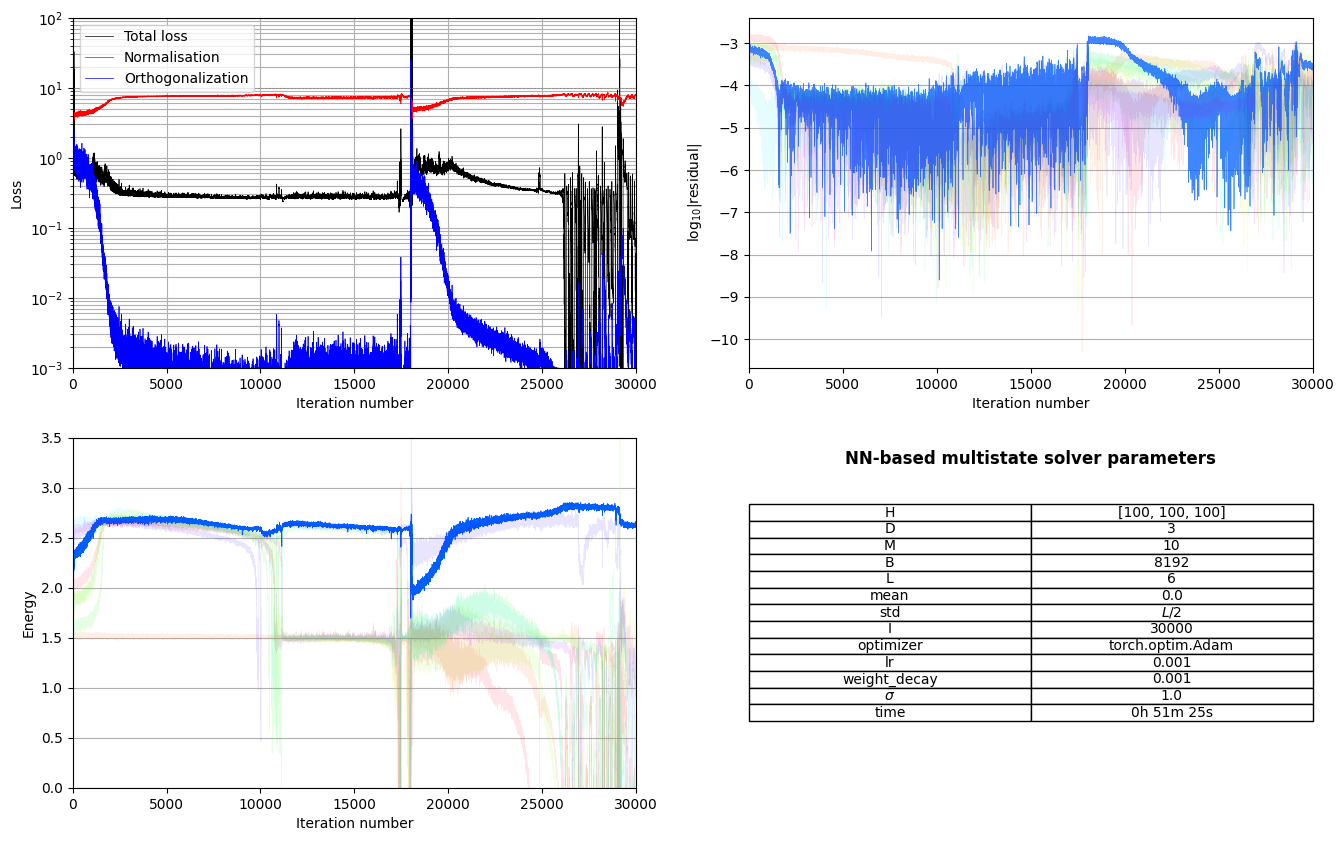

In [17]:
fig, ax = plt.subplots(2,2,figsize=(16,10))

NUM_COLORS = params['M']

cm = plt.get_cmap('gist_rainbow')
# Loss

ax[0,1].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

ax[0,0].plot(l_list, linewidth=0.5, color='black', label='Total loss')
# ax[0,0].plot(np.array(l_list) - np.array(a_list) - 100*np.array(b_list), linewidth=0.5, color='green', label='1st term')
ax[0,0].plot(a_list, linewidth=0.5, color='red', label='Normalisation')
ax[0,0].plot(b_list, linewidth=0.5, color='blue', label='Orthogonalization')
ax[0,0].axhline(y=10,linewidth=0.5, linestyle='--', color='grey')
ax[0,0].legend()
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(0,params['I'])
ax[0,0].set_ylim(1e-3,1e2)
ax[0,0].set_ylabel('Loss')
ax[0,0].set_xlabel('Iteration number')
ax[0,0].grid(True,which="both")


ax[1,0].set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for m in range(perceptron.M):
  if np.array(e_list)[-2500:,m].std() < 0.25:
    alpha = 1
  else:
    alpha = 0.1
  ax[1,0].plot(np.array(e_list)[:,m],# color=colors[m], 
               linewidth=0.5, alpha=alpha)
ax[1,0].set_xlim(0,params['I'])
ax[1,0].set_ylim(0,3)
ax[1,0].set_yticks(np.arange(0,3+1,0.5))
# ax[1,0].set_yscale('symlog')
ax[1,0].grid(axis='y')
ax[1,0].set_ylabel('Energy')
ax[1,0].set_xlabel('Iteration number')

for m in range(perceptron.M):
  if np.array(e_list)[-2500:,m].std() < 0.25:
    alpha = 0.75
  else:
    alpha = 0.1
  ax[0,1].plot(np.log10(abs(np.array(r_list)[:,m])),# color=colors[m], 
               linewidth=0.5, alpha=alpha)
ax[0,1].set_xlim(0,params['I'])
ax[0,1].grid(axis='y')
ax[0,1].set_ylabel(r'$\mathrm{log}_{10}|\mathrm{residual}|$')
ax[0,1].set_xlabel('Iteration number')
# ax[1,0].set_yscale('log')

# Table
vars=['H','D','M','B','L','mean','std','I','optimizer',
      'lr','weight_decay',r'$\sigma$','time']
vals=[params['H'],perceptron.D,perceptron.M,params['B'],params['L'],0.0,r'$L/2$',params['I'],'torch.optim.Adam',
      1e-3,1e-3,params['sigma'],f"{int(t//3600):}h {int(t/60 - 60 * int(t//3600)):}m {int(t - 60 * int(t/60 - 60 * int(t//3600)))}s"]
ax[1,1].set_axis_off()
ax[1,1].table(cellText = np.array([vars,vals]).transpose(),
              cellLoc ='center',  
              loc ='center')
ax[1,1].set_title('NN-based multistate solver parameters', fontweight ="bold", y=0.9)

print(np.sort(np.array(e_list)[-1,:]))

fig.savefig(path+params['nnbmssPathFigure'])

In [18]:
np.sort(np.min(np.array(e_list)[-500:,:],axis=0))

array([-8.79282  , -7.882368 , -7.1430836, -3.7739546, -1.6370245,
       -1.0930235,  0.8766038,  0.9111426,  1.3063719,  2.5851717],
      dtype=float32)